https://www.kaggle.com/code/kariim/rossmann/notebook

# Load libraries

In [167]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [168]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [169]:
Main_dir = '/content/drive/MyDrive/PostDoc/Time Series/'
Main_dir_data = Main_dir + '/Sample_practice/rossmann-store-sales/'

# Functions

In [170]:
def convert_date(df):
    df['Date']=pd.to_datetime(df['Date'])
    df['Year']=df.Date.dt.year
    df['Month']=df.Date.dt.month
    df['Day']=df.Date.dt.day
    df['WeekOfYear']=df.Date.dt.isocalendar().week

In [171]:
# Competition convert all years to months 
def com_month(df):
    df['CompetitionOpen']=12*(df['Year'] - df['CompetitionOpenSinceYear'])
    +(df['Month'] - df['CompetitionOpenSinceMonth'])
    df['CompetitionOpen']=df['CompetitionOpen'].map(lambda x:0 if x<0 else x).fillna(0)

In [172]:
def check_promo_month(data):
    month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',              
                 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    try:
        months = (data['PromoInterval'] or '').split(',')
        if data['Promo2Open'] and month2str[data['Month']] in months:
            return 1
        else:
            return 0
    except Exception:
        return 0
def promo_cols(df):
    # Months since Promo2 was open
    df['Promo2Open'] = 12 * (df.Year - df.Promo2SinceYear) +  (df.WeekOfYear - df.Promo2SinceWeek)*7/30
    df['Promo2Open'] = df['Promo2Open'].map(lambda x: 0 if x < 0 else x).fillna(0) * df['Promo2']
    # Whether a new round of promotions was started in the current month
    df['IsPromo2Month'] = df.apply(check_promo_month, axis=1) * df['Promo2']

# [Rossmann Dataset](https://www.kaggle.com/competitions/rossmann-store-sales/code)

Store - a unique Id for each store

StoreType - differentiates between 4 different store models: a, b, c, d

Assortment - describes an assortment level: a = basic, b = extra, c = extended

CompetitionDistance - distance in meters to the nearest competitor store

CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened

Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating

Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2

PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [173]:
Rossmann_data_store = pd.read_csv(Main_dir_data + 'store.csv')
print(Rossmann_data_store.shape)
Rossmann_data_store.head()

(1115, 10)


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [174]:
Rossmann_data_store['StoreType'].value_counts()

a    602
d    348
c    148
b     17
Name: StoreType, dtype: int64

In [175]:
Rossmann_data_store['Assortment'].value_counts()

a    593
c    513
b      9
Name: Assortment, dtype: int64

Id - an Id that represents a (Store, Date) duple within the test set

Store - a unique Id for each store

Sales - the turnover for any given day (this is what you are predicting)

Customers - the number of customers on a given day

Open - an indicator for whether the store was open: 0 = closed, 1 = open

StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None

SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools

Promo - indicates whether a store is running a promo on that day


In [176]:
Rossmann_data = pd.read_csv(Main_dir_data + 'train.csv')
Rossmann_data_test = pd.read_csv(Main_dir_data + 'test.csv')
print(Rossmann_data.shape, Rossmann_data_test.shape)

(1017209, 9) (41088, 8)


/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [107]:
Rossmann_data.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [177]:
Rossmann_data=Rossmann_data.merge(Rossmann_data_store,how='left',on='Store')
Rossmann_data_test=Rossmann_data_test.merge(Rossmann_data_store,how='left',on='Store')

In [109]:
Rossmann_data.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [110]:
Rossmann_data_test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,1,4,2015-09-17,1.0,1,0,0,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,3,4,2015-09-17,1.0,1,0,0,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
2,3,7,4,2015-09-17,1.0,1,0,0,a,c,24000.0,4.0,2013.0,0,NaN,NaN,NaN
3,4,8,4,2015-09-17,1.0,1,0,0,a,a,7520.0,10.0,2014.0,0,NaN,NaN,NaN
4,5,9,4,2015-09-17,1.0,1,0,0,a,c,2030.0,8.0,2000.0,0,NaN,NaN,NaN


In [111]:
Rossmann_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Date                       1017209 non-null  object 
 3   Sales                      1017209 non-null  int64  
 4   Customers                  1017209 non-null  int64  
 5   Open                       1017209 non-null  int64  
 6   Promo                      1017209 non-null  int64  
 7   StateHoliday               1017209 non-null  object 
 8   SchoolHoliday              1017209 non-null  int64  
 9   StoreType                  1017209 non-null  object 
 10  Assortment                 1017209 non-null  object 
 11  CompetitionDistance        1014567 non-null  float64
 12  CompetitionOpenSinceMonth  693861 non-null   float64
 13  CompetitionO

In [178]:
convert_date(Rossmann_data)
convert_date(Rossmann_data_test)

In [179]:
Rossmann_data.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear
0,1,5,2015-07-31,5263,555,1,1,0,1,c,...,9.0,2008.0,0,NaN,NaN,NaN,2015,7,31,31
1,2,5,2015-07-31,6064,625,1,1,0,1,a,...,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2015,7,31,31
2,3,5,2015-07-31,8314,821,1,1,0,1,a,...,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,7,31,31
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,...,9.0,2009.0,0,NaN,NaN,NaN,2015,7,31,31
4,5,5,2015-07-31,4822,559,1,1,0,1,a,...,4.0,2015.0,0,NaN,NaN,NaN,2015,7,31,31


In [180]:
com_month(Rossmann_data)
com_month(Rossmann_data_test)

In [181]:
Rossmann_data.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear,CompetitionOpen
0,1,5,2015-07-31,5263,555,1,1,0,1,c,...,2008.0,0,NaN,NaN,NaN,2015,7,31,31,84.0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,...,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2015,7,31,31,96.0
2,3,5,2015-07-31,8314,821,1,1,0,1,a,...,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,7,31,31,108.0
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,...,2009.0,0,NaN,NaN,NaN,2015,7,31,31,72.0
4,5,5,2015-07-31,4822,559,1,1,0,1,a,...,2015.0,0,NaN,NaN,NaN,2015,7,31,31,0.0


In [182]:
promo_cols(Rossmann_data)
promo_cols(Rossmann_data_test)

In [183]:
Rossmann_data.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear,CompetitionOpen,Promo2Open,IsPromo2Month
0,1,5,2015-07-31,5263,555,1,1,0,1,c,...,NaN,NaN,NaN,2015,7,31,31,84.0,0.000000,0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,...,13.0,2010.0,"Jan,Apr,Jul,Oct",2015,7,31,31,96.0,64.200000,1
2,3,5,2015-07-31,8314,821,1,1,0,1,a,...,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,7,31,31,108.0,51.966667,1
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,...,NaN,NaN,NaN,2015,7,31,31,72.0,0.000000,0
4,5,5,2015-07-31,4822,559,1,1,0,1,a,...,NaN,NaN,NaN,2015,7,31,31,0.0,0.000000,0


In [184]:
Rossmann_data.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'Year', 'Month', 'Day',
       'WeekOfYear', 'CompetitionOpen', 'Promo2Open', 'IsPromo2Month'],
      dtype='object')

In [185]:
Rossmann_data = Rossmann_data.drop(["CompetitionOpenSinceYear", "CompetitionOpenSinceMonth", "Promo2SinceWeek", "Promo2SinceYear", "PromoInterval"],axis=1)
Rossmann_data.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,Promo2,Year,Month,Day,WeekOfYear,CompetitionOpen,Promo2Open,IsPromo2Month
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,0,2015,7,31,31,84.0,0.000000,0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,1,2015,7,31,31,96.0,64.200000,1
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,1,2015,7,31,31,108.0,51.966667,1
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,0,2015,7,31,31,72.0,0.000000,0
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,0,2015,7,31,31,0.0,0.000000,0


In [120]:
Rossmann_data[Rossmann_data.duplicated()].count()


Store                  0
DayOfWeek              0
Date                   0
Sales                  0
Customers              0
Open                   0
Promo                  0
StateHoliday           0
SchoolHoliday          0
StoreType              0
Assortment             0
CompetitionDistance    0
Promo2                 0
Year                   0
Month                  0
Day                    0
WeekOfYear             0
CompetitionOpen        0
Promo2Open             0
IsPromo2Month          0
dtype: int64

In [186]:
Rossmann_data_test = Rossmann_data_test.drop(["CompetitionOpenSinceYear", "CompetitionOpenSinceMonth", "Promo2SinceWeek", "Promo2SinceYear", "PromoInterval"],axis=1)
Rossmann_data_test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,Promo2,Year,Month,Day,WeekOfYear,CompetitionOpen,Promo2Open,IsPromo2Month
0,1,1,4,2015-09-17,1.0,1,0,0,c,a,1270.0,0,2015,9,17,38,84.0,0.0,0
1,2,3,4,2015-09-17,1.0,1,0,0,a,a,14130.0,1,2015,9,17,38,108.0,53.6,0
2,3,7,4,2015-09-17,1.0,1,0,0,a,c,24000.0,0,2015,9,17,38,24.0,0.0,0
3,4,8,4,2015-09-17,1.0,1,0,0,a,a,7520.0,0,2015,9,17,38,12.0,0.0,0
4,5,9,4,2015-09-17,1.0,1,0,0,a,c,2030.0,0,2015,9,17,38,180.0,0.0,0


In [187]:
Rossmann_data_test[Rossmann_data_test.duplicated()].count()


Id                     0
Store                  0
DayOfWeek              0
Date                   0
Open                   0
Promo                  0
StateHoliday           0
SchoolHoliday          0
StoreType              0
Assortment             0
CompetitionDistance    0
Promo2                 0
Year                   0
Month                  0
Day                    0
WeekOfYear             0
CompetitionOpen        0
Promo2Open             0
IsPromo2Month          0
dtype: int64

In [123]:
Rossmann_data_test.isnull().sum().sort_values(ascending=False)

CompetitionDistance    96
Open                   11
Id                      0
Promo2Open              0
CompetitionOpen         0
WeekOfYear              0
Day                     0
Month                   0
Year                    0
Promo2                  0
Assortment              0
Store                   0
StoreType               0
SchoolHoliday           0
StateHoliday            0
Promo                   0
Date                    0
DayOfWeek               0
IsPromo2Month           0
dtype: int64

In [124]:
Rossmann_data.isnull().sum().sort_values(ascending=False)

CompetitionDistance    2642
Store                     0
DayOfWeek                 0
Promo2Open                0
CompetitionOpen           0
WeekOfYear                0
Day                       0
Month                     0
Year                      0
Promo2                    0
Assortment                0
StoreType                 0
SchoolHoliday             0
StateHoliday              0
Promo                     0
Open                      0
Customers                 0
Sales                     0
Date                      0
IsPromo2Month             0
dtype: int64

# missing data

In [139]:
Rossmann_data[Rossmann_data['CompetitionDistance'].isnull()]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,Promo2,Year,Month,Day,WeekOfYear,CompetitionOpen,Promo2Open,IsPromo2Month
290,291,5,2015-07-31,10052,973,1,1,0,1,d,a,NaN,0,2015,7,31,31,0.0,0.000000,0
621,622,5,2015-07-31,6306,540,1,1,0,1,a,c,NaN,0,2015,7,31,31,0.0,0.000000,0
878,879,5,2015-07-31,6000,466,1,1,0,0,d,a,NaN,1,2015,7,31,31,0.0,30.066667,0
1405,291,4,2015-07-30,9030,883,1,1,0,1,d,a,NaN,0,2015,7,30,31,0.0,0.000000,0
1736,622,4,2015-07-30,5412,406,1,1,0,1,a,c,NaN,0,2015,7,30,31,0.0,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1015601,622,3,2013-01-02,4080,451,1,0,0,1,a,c,NaN,0,2013,1,2,1,0.0,0.000000,0
1015858,879,3,2013-01-02,3077,326,1,0,0,1,d,a,NaN,1,2013,1,2,1,0.0,0.000000,0
1016385,291,2,2013-01-01,0,0,0,0,a,1,d,a,NaN,0,2013,1,1,1,0.0,0.000000,0
1016716,622,2,2013-01-01,0,0,0,0,a,1,a,c,NaN,0,2013,1,1,1,0.0,0.000000,0


In [142]:
Rossmann_data_test[Rossmann_data_test['CompetitionDistance'].isnull()]['Store'].value_counts()

622    48
879    48
Name: Store, dtype: int64

In [143]:
Rossmann_data[Rossmann_data['CompetitionDistance'].isnull()]['Store'].value_counts()

291    942
622    942
879    758
Name: Store, dtype: int64

In [144]:
Rossmann_data_test[Rossmann_data_test['Open'].isnull()]['Store'].value_counts()

622    11
Name: Store, dtype: int64

In [145]:
Rossmann_data_test[Rossmann_data_test['Open'].isnull()]

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,Promo2,Year,Month,Day,WeekOfYear,CompetitionOpen,Promo2Open,IsPromo2Month
479,480,622,4,2015-09-17,NaN,1,0,0,a,c,NaN,0,2015,9,17,38,0.0,0.0,0
1335,1336,622,3,2015-09-16,NaN,1,0,0,a,c,NaN,0,2015,9,16,38,0.0,0.0,0
2191,2192,622,2,2015-09-15,NaN,1,0,0,a,c,NaN,0,2015,9,15,38,0.0,0.0,0
3047,3048,622,1,2015-09-14,NaN,1,0,0,a,c,NaN,0,2015,9,14,38,0.0,0.0,0
4759,4760,622,6,2015-09-12,NaN,0,0,0,a,c,NaN,0,2015,9,12,37,0.0,0.0,0
5615,5616,622,5,2015-09-11,NaN,0,0,0,a,c,NaN,0,2015,9,11,37,0.0,0.0,0
6471,6472,622,4,2015-09-10,NaN,0,0,0,a,c,NaN,0,2015,9,10,37,0.0,0.0,0
7327,7328,622,3,2015-09-09,NaN,0,0,0,a,c,NaN,0,2015,9,9,37,0.0,0.0,0
8183,8184,622,2,2015-09-08,NaN,0,0,0,a,c,NaN,0,2015,9,8,37,0.0,0.0,0
9039,9040,622,1,2015-09-07,NaN,0,0,0,a,c,NaN,0,2015,9,7,37,0.0,0.0,0


In [188]:
Rossmann_data = Rossmann_data[~Rossmann_data['CompetitionDistance'].isnull()]

In [189]:
Rossmann_data_test = Rossmann_data_test[~Rossmann_data_test['CompetitionDistance'].isnull()]

In [190]:
Rossmann_data['StateHoliday'] = Rossmann_data['StateHoliday'].apply(lambda x: 0 if x =='0' else x)

In [191]:
Rossmann_data_test['StateHoliday'] = Rossmann_data_test['StateHoliday'].apply(lambda x: 0 if x =='0' else x)

# Plots

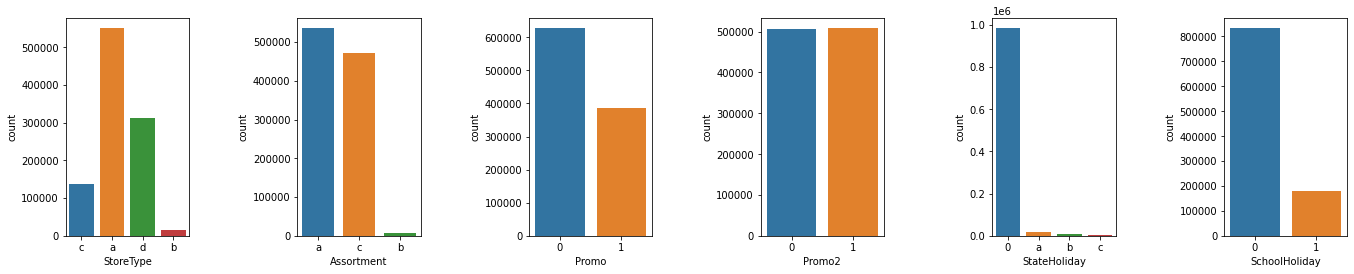

In [192]:
fig, axes = plt.subplots(1, 6, figsize=(20, 5))
sns.countplot(ax=axes[0],data=Rossmann_data,x='StoreType')
sns.countplot(ax=axes[1],data=Rossmann_data,x='Assortment')
sns.countplot(ax=axes[2],data=Rossmann_data,x='Promo')
sns.countplot(ax=axes[3],data=Rossmann_data,x='Promo2')
sns.countplot(ax=axes[4],data=Rossmann_data,x='StateHoliday')
sns.countplot(ax=axes[5],data=Rossmann_data,x='SchoolHoliday')

fig.tight_layout(pad=5.0)
 
plt.show()

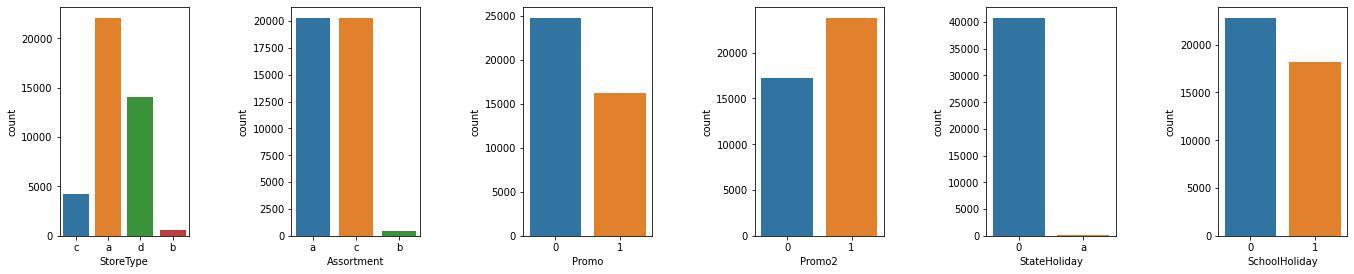

In [193]:
fig, axes = plt.subplots(1, 6, figsize=(20, 5))
sns.countplot(ax=axes[0],data=Rossmann_data_test,x='StoreType')
sns.countplot(ax=axes[1],data=Rossmann_data_test,x='Assortment')
sns.countplot(ax=axes[2],data=Rossmann_data_test,x='Promo')
sns.countplot(ax=axes[3],data=Rossmann_data_test,x='Promo2')
sns.countplot(ax=axes[4],data=Rossmann_data_test,x='StateHoliday')
sns.countplot(ax=axes[5],data=Rossmann_data_test,x='SchoolHoliday')

fig.tight_layout(pad=5.0)
 
plt.show()

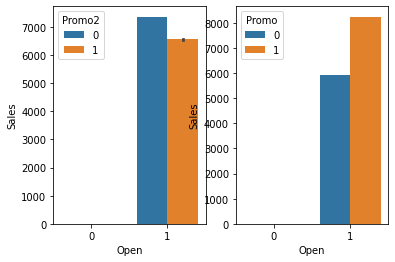

In [194]:
fig, axes = plt.subplots(1, 2)

sns.barplot(ax=axes[0],data=Rossmann_data, x="Open", y="Sales", hue="Promo2")
sns.barplot(ax=axes[1],data=Rossmann_data, x="Open", y="Sales", hue="Promo")
plt.show()

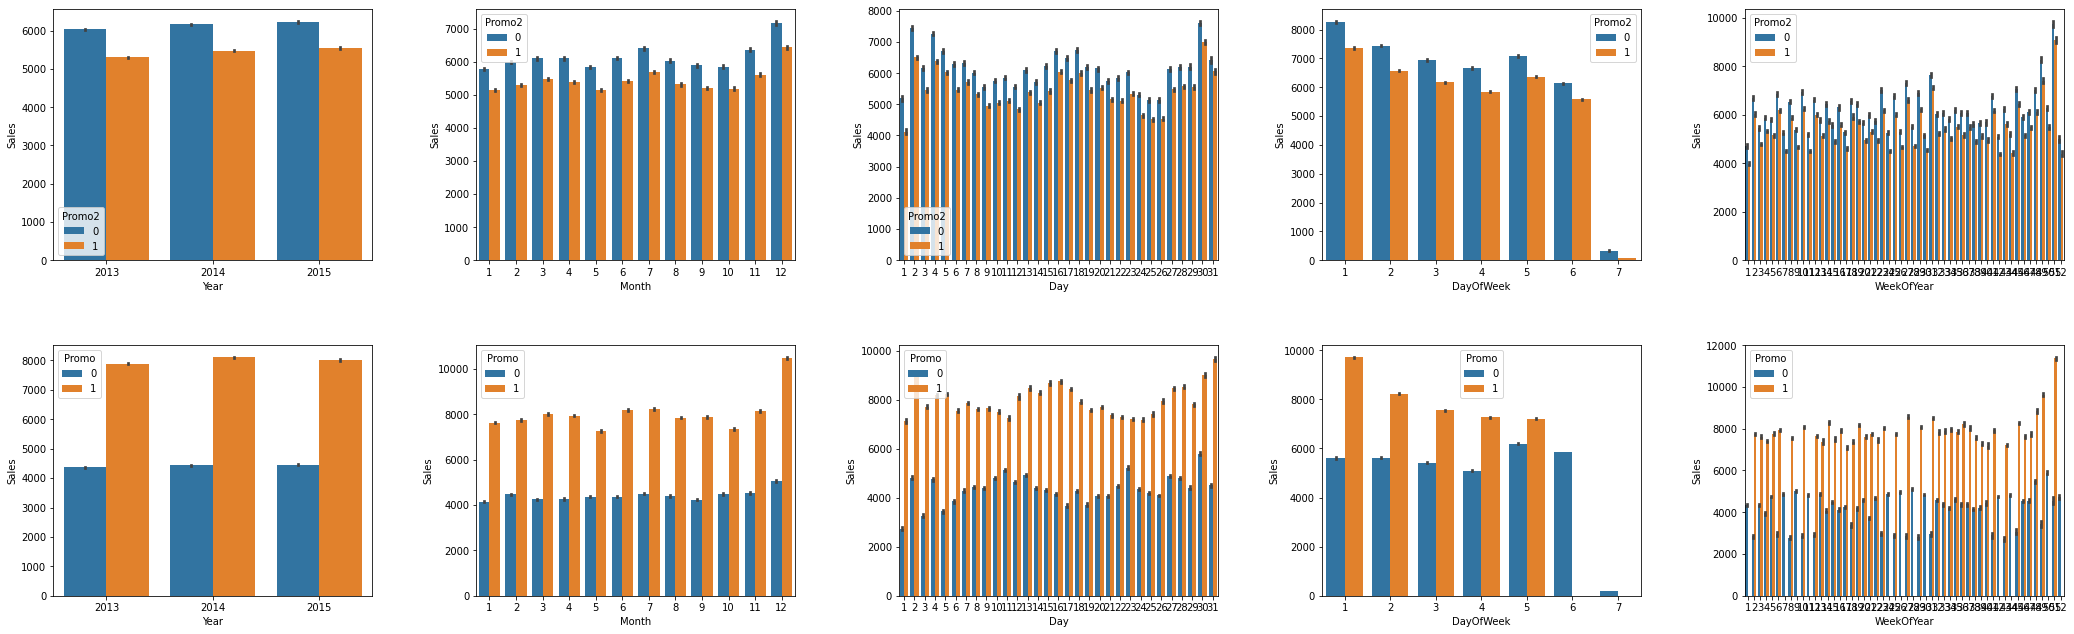

In [198]:
fig, axes = plt.subplots(2, 5, figsize=(30, 10))

sns.barplot(ax=axes[0,0],data=Rossmann_data, x="Year", y="Sales", hue="Promo2")
sns.barplot(ax=axes[1,0],data=Rossmann_data, x="Year", y="Sales", hue="Promo")

sns.barplot(ax=axes[0,1],data=Rossmann_data, x="Month", y="Sales", hue="Promo2")
sns.barplot(ax=axes[1,1],data=Rossmann_data, x="Month", y="Sales", hue="Promo")

sns.barplot(ax=axes[0,2],data=Rossmann_data, x="Day", y="Sales", hue="Promo2")
sns.barplot(ax=axes[1,2],data=Rossmann_data, x="Day", y="Sales", hue="Promo")

sns.barplot(ax=axes[0,3],data=Rossmann_data, x="DayOfWeek", y="Sales", hue="Promo2")
sns.barplot(ax=axes[1,3],data=Rossmann_data, x="DayOfWeek", y="Sales", hue="Promo")

sns.barplot(ax=axes[0,4],data=Rossmann_data, x="WeekOfYear", y="Sales", hue="Promo2")
sns.barplot(ax=axes[1,4],data=Rossmann_data, x="WeekOfYear", y="Sales", hue="Promo")
fig.tight_layout(pad=5.0)
plt.show()

In [199]:
Rossmann_data.shape, Rossmann_data_test.shape

((1014567, 20), (40992, 19))

In [200]:
Rossmann_data.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,Promo2,Year,Month,Day,WeekOfYear,CompetitionOpen,Promo2Open,IsPromo2Month
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,0,2015,7,31,31,84.0,0.000000,0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,1,2015,7,31,31,96.0,64.200000,1
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,1,2015,7,31,31,108.0,51.966667,1
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,0,2015,7,31,31,72.0,0.000000,0
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,0,2015,7,31,31,0.0,0.000000,0


In [205]:
Rossmann_data['Open'].value_counts()

1    842206
0    172361
Name: Open, dtype: int64

In [207]:
Rossmann_data['SchoolHoliday'].value_counts()

0    833301
1    181266
Name: SchoolHoliday, dtype: int64

In [208]:
inputs_col=['Store','Open', 'Promo','SchoolHoliday','CompetitionDistance',
       'Promo2','Year','Month','Day','WeekOfYear', 
        'CompetitionOpen', 'Promo2Open', 'IsPromo2Month',
            'DayOfWeek','StateHoliday','StoreType','Assortment']
target_col='Sales'
inputs=Rossmann_data[inputs_col].copy()
target=Rossmann_data[target_col].copy()

In [209]:
test_inputs=Rossmann_data_test[inputs_col].copy()

In [ ]:
num_col=['Store','Promo','SchoolHoliday','CompetitionDistance',
       'Promo2','Year','Month','Day','WeekOfYear', 
        'CompetitionOpen', 'Promo2Open', 'IsPromo2Month']
cat_col=['DayOfWeek','StateHoliday','StoreType','Assortment']

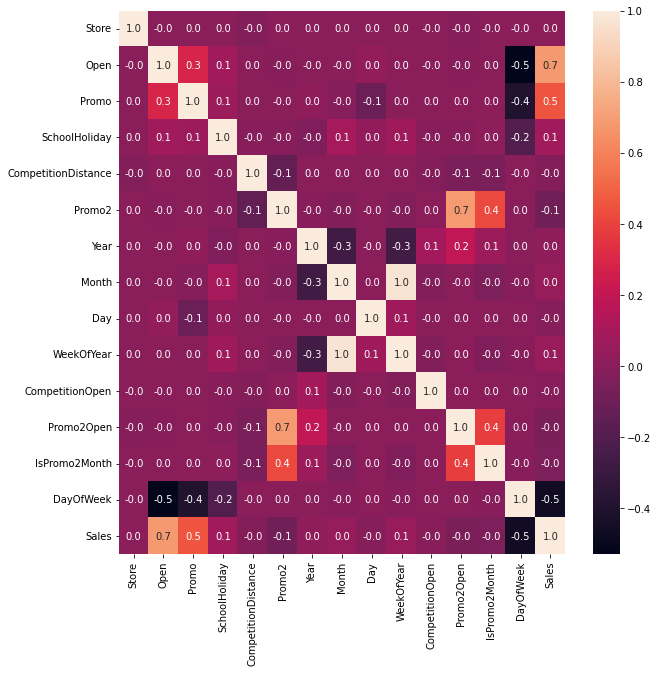

In [215]:
fig, axes = plt.subplots(1, 1, figsize=(10, 10))
sns.heatmap(Rossmann_data[['Store','Open', 'Promo','SchoolHoliday','CompetitionDistance',
       'Promo2','Year','Month','Day','WeekOfYear', 
        'CompetitionOpen', 'Promo2Open', 'IsPromo2Month',
            'DayOfWeek','StateHoliday','StoreType','Assortment','Sales']].corr(),annot=True, fmt=".1f")